In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list the files in the input directory

import os
print(os.listdir("../input"))

# Any results you write to the current directory are saved as output.

In [2]:

from keras import layers
from keras import models
from keras.utils import to_categorical
import matplotlib.pyplot as plt
from os import listdir, makedirs
import numpy as np
from keras.preprocessing.image import ImageDataGenerator
from keras.applications import VGG16, ResNet50, VGG19
from keras.models import Sequential
from keras.layers import Dense, Flatten, Dropout
from keras import optimizers, regularizers

/opt/conda/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [ ]:
ls

In [9]:
RESOLUTION = 150
BATCH_SIZE=64

#if you need data augmentation processing
#train_datagen = ImageDataGenerator(
        #rescale=1./255,
        #shear_range=0.2,
        #zoom_range=0.2,
        #horizontal_flip=True,
        #validation_split=0.3)

train_datagen = ImageDataGenerator(rescale=1./255, validation_split=0.3,)
val_datagen = ImageDataGenerator(rescale=1./255, validation_split=0.3)

train_generator = train_datagen.flow_from_directory(
        "../input/state-farm-distracted-driver-detection/train/",
        target_size=(RESOLUTION, RESOLUTION),
        batch_size=BATCH_SIZE,
        class_mode='categorical', subset="training")

val_generator = val_datagen.flow_from_directory(
        "../input/state-farm-distracted-driver-detection/train/",
        target_size=(RESOLUTION, RESOLUTION),
        batch_size=BATCH_SIZE,
        class_mode='categorical', subset="validation")

Found 15702 images belonging to 10 classes.
Found 6722 images belonging to 10 classes.


In [3]:
path = "../input/vgg19/vgg19_weights_tf_dim_ordering_tf_kernels_notop.h5"
conv_base = VGG19(include_top=False, input_shape=(150, 150, 3), weights=path)

In [4]:

conv_base.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 150, 150, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 150, 150, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 150, 150, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 75, 75, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 75, 75, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 75, 75, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 37, 37, 128)       0         
__________

In [5]:
def vgg19_pretrained_model(model_vgg, dropout_=False, regularizer_=False, regularizer_weight=0.001):
  
    model = Sequential()
    model.add(model_vgg)
    model.add(Flatten())
    if dropout_:
        model.add(Dropout(0.5))
    if regularizer_:
        model.add(Dense(256, activation='relu', kernel_regularizer=regularizers.l1_l2(l1=regularizer_weight,
                                                                                            l2=regularizer_weight)))
    else:
        model.add(Dense(256, activation='relu'))
    model.add(Dense(10, activation='softmax'))
    model.summary()
    model.compile(loss='categorical_crossentropy', optimizer=optimizers.RMSprop(lr=1e-5), metrics=['acc'])

    return model

In [6]:

model = vgg19_pretrained_model(conv_base, dropout_=False, regularizer_=False, regularizer_weight=0.001)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg19 (Model)                (None, 4, 4, 512)         20024384  
_________________________________________________________________
flatten_1 (Flatten)          (None, 8192)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 256)               2097408   
_________________________________________________________________
dense_2 (Dense)              (None, 10)                2570      
Total params: 22,124,362
Trainable params: 22,124,362
Non-trainable params: 0
_________________________________________________________________


In [11]:
N_TRAIN = 15702
N_VAL = 6722
history = model.fit_generator(
        train_generator,
        steps_per_epoch=(N_TRAIN // BATCH_SIZE),
        epochs=10,
        validation_data=val_generator,
        validation_steps=(N_VAL // BATCH_SIZE))

Epoch 1/10
245/245 [==============================] - 300s 1s/step - loss: 0.4476 - acc: 0.8642 - val_loss: 0.0825 - val_acc: 0.9766
Epoch 2/10
245/245 [==============================] - 285s 1s/step - loss: 0.0588 - acc: 0.9839 - val_loss: 0.0618 - val_acc: 0.9824
Epoch 3/10
245/245 [==============================] - 283s 1s/step - loss: 0.0244 - acc: 0.9929 - val_loss: 0.0288 - val_acc: 0.9939
Epoch 4/10
245/245 [==============================] - 281s 1s/step - loss: 0.0183 - acc: 0.9952 - val_loss: 0.0262 - val_acc: 0.9938
Epoch 5/10
245/245 [==============================] - 285s 1s/step - loss: 0.0112 - acc: 0.9968 - val_loss: 0.0303 - val_acc: 0.9940
Epoch 6/10
245/245 [==============================] - 286s 1s/step - loss: 0.0087 - acc: 0.9971 - val_loss: 0.0242 - val_acc: 0.9942
Epoch 7/10
245/245 [==============================] - 286s 1s/step - loss: 0.0073 - acc: 0.9978 - val_loss: 0.0226 - val_acc: 0.9942
Epoch 8/10
245/245 [==============================] - 285s 1s/step - 

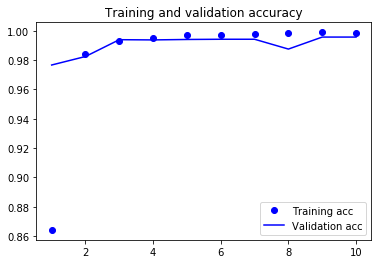

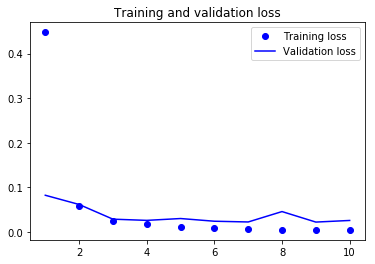

In [13]:
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc) + 1)

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend(loc='best')

plt.figure()
plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend(loc='best');